# Проект Маркетинг

Данное исследование проводится для интернет-магазина с целью подготовки модели машинного обучения, которая будет предсказывать вероятность совершения покупателем покупки в течение 90 дней.

Необходимо:
- Изучить данные, провести их предобработку (при наличии и по возможности избавиться от выбросов и аномалий, заполнить пропущенные значения, т.д.).
- Провести исследовательский анализ.
- При необходимости сформировать новые признаки.
- Проверить данные на мультиколлинеарность.
- Подготовить и обучить модель на имеющихся данных.
- Оценить работу модели по метрике качества и максимизировать ее по возможности.

В данном проекте будет использоваться метрика ROC-AUC для определения качества работы модели.

Имеются следующие данные:
- История покупок (apparel-purchases) - содержит данные о покупках клиентов по дням и по товарам. В каждой записи покупка
определенного товара, его цена, количество штук, а также в таблице есть списки идентификаторов, к каким категориям относится товар.
- История рекламных рассылок (apparel-messages) - содержит данные по рассылкам клиентам из Истории покупок.
- Таблица с целевыми значениями (apparel-target_binary).

Так как общая база рассылок огромна, отдельно собранна агрегированная по дням статистика по рассылкам:
- По дням и типам событий (full_campaign_daily_event).
- По дням с учетом событий и каналов рассылки (full_campaign_daily_event_channel).

In [117]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import phik
from phik.report import plot_correlation_matrix

from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Подготовка и анализ данных

## Загрузка и ознакомление с данными

Загрузим имеющиеся у нас данные и предварительно рассмотрим их.

In [118]:
df = pd.read_csv('DS/apparel-purchases.csv')
target = pd.read_csv('DS/apparel-target_binary.csv')

messages = pd.read_csv('DS/apparel-messages.csv')

In [119]:
#Зададим функцию, которая выведет обзор данных из датасета
def parse(ds):
    print('\033[1mПервые 5 строк датасета\033[0m')
    display(ds.head(5))
    
    print('\n\033[1mИнформация о структуре датасета:\033[0m')
    ds.info()
    
    #Проверка на пропуски
    #Абсолютные
    total_missing = ds.isnull().sum()
    print(f'\n\033[1mВсего пропущенных значений:\n\033[0m{total_missing}')
    #Относительные
    rows = len(ds)
    columns = len(ds.columns)
    total_cells = rows * columns
    missing = round(total_missing / total_cells * 100, 2)
    print(f'\n\033[1mПропусков относительно всех ячеек:\n\033[0m{missing}%')

    # Проверка на наличие явных дубликатов
    duplicates = ds.duplicated().sum()
    print(f'\n\033[1mЯвных дубликатов, в строках:\n\033[0m{duplicates}')
    part_dup = round(duplicates / rows * 100, 2)
    print(f'\033[1mДоля явных дубликатов от общего количества строк:\n\033[0m{part_dup}%\n')

    print('\033[1mРаспределение данных количественных столбцов\033[0m')
    display(ds.describe())

    # Уникальные значения категориальных столбцов
    cat_cols = ds.select_dtypes(exclude=['int', 'float']).columns
    print('\n\033[1mУникальные значения категориальных столбцов:\033[0m')
    for col in cat_cols:
        unique = ds[col].unique()
        print(f'{col}: {len(unique)} уникальных значений')

### Датасет df

In [120]:
parse(df)

Первые 5 строк датасета


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843



Информация о структуре датасета:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB

Всего пропущенных значений:
client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64

Пропусков относительно всех ячеек:
client_id       0.0
quantity        0.0
price           0.0
category_ids    0.0
date            0.0
message_id      0.0
dtype: float64%

Явных дубликатов, в строках:
73020
Доля явных дубликатов от общего количества строк:
36.11%

Распределение данных колич

,client_id,quantity,price
count,2.022080e+05,202208.000000,202208.000000
mean,1.515916e+18,1.006483,1193.301516
std,1.459458e+08,0.184384,1342.252664
min,1.515916e+18,1.000000,1.000000
25%,1.515916e+18,1.000000,352.000000
50%,1.515916e+18,1.000000,987.000000
75%,1.515916e+18,1.000000,1699.000000
max,1.515916e+18,30.000000,85499.000000



Уникальные значения категориальных столбцов:
category_ids: 933 уникальных значений
date: 642 уникальных значений
message_id: 50204 уникальных значений


Отметим следующее:
- Явных пропусков в датасете нет.
- Столбец date имеет тип object, вместо ожидаемого datetime. Возможно потребует корректировки.
- В столбце quantity потенциально аномальное распределение данных (от минимума до 3 квартиля значение 1, а максимальное - 30).
- В столбце price также широкий диапазон данных, медиана и среднее достаточно удаленны друг от друга, возможно наличие выбросов в данных.
- Количество явных дубликатов чрезмерно большое (более 1/3 данных).

Рассмотрим отдельно, есть ли закономерность в дубликатах.

In [121]:
df.sort_values(by='client_id', ascending=False).head(15)

,client_id,quantity,price,category_ids,date,message_id
202207,1515915626010443624,1,999.0,"['4', '28', '62', '656']",2024-02-16,1515915625488468007-14668-65cf5234b1295
202206,1515915626010443527,1,1999.0,"['2', '18', '274', '446']",2024-02-16,1515915625766077627-14668-65cf5246bd490
202205,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d
202204,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d
201564,1515915626010266132,1,909.0,"['4', '27', '278', '470']",2024-02-14,1515915625999374481-14623-65c5c5acbad8c
201563,1515915626010266132,1,909.0,"['4', '27', '278', '470']",2024-02-14,1515915625999374481-14623-65c5c5acbad8c
202202,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8
202201,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8
202200,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8
202199,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8


Так как информация о покупке не содержит данные о времени покупки, сложно объективно оценить, насколько эти данные являются некорректными. Теоретически клиент действительно мог несколько раз купить один и тот же товар несколько раз в течение одного дня. 

Либо же система могла некорретно сохранить данные и "разбить" одну покупку нескольких единиц на несколько разных покупок. Это бы также объяснило перекос в количестве купленных товаров, который отмечали ранее (что большинство товаров куплено в количестве 1 единицы). 

Кроме того, заметим, что дубликаты в исходных данных идут последовательно (о чем нам говорит номер строки), соответственно записи сохранились одна за другой. Так как количество дублирующихся строк неодинаково для каждрй из покупок, то, вероятнее всего, в данном случае речь идет все же об одной и той же покупке нескольких единиц.

В данном случае, для корректировки сгруппируем данные, просуммировав их по столбцу quantity.

In [122]:
df = df.groupby(['client_id', 'price', 'category_ids', 'date', 'message_id'])['quantity'].sum().reset_index()

df.sort_values(by='client_id', ascending=False).head(15)

,client_id,price,category_ids,date,message_id,quantity
129017,1515915626010443624,999.0,"['4', '28', '62', '656']",2024-02-16,1515915625488468007-14668-65cf5234b1295,1
129016,1515915626010443527,1999.0,"['2', '18', '274', '446']",2024-02-16,1515915625766077627-14668-65cf5246bd490,1
129015,1515915626010439406,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d,2
129014,1515915626010266132,909.0,"['4', '27', '278', '470']",2024-02-14,1515915625999374481-14623-65c5c5acbad8c,2
129013,1515915626010261344,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8,6
129012,1515915626010256069,1999.0,"['5562', '5599', '5553', '1080']",2024-02-14,1515915625804234758-14641-65cb24d54a98d,2
129011,1515915626010221592,1499.0,"['4', '28', '260', '1194']",2024-02-16,1515915626010221592-14664-65cf1622434a9,2
129010,1515915626010206841,1999.0,"['4', '28', '58', '1560']",2024-02-13,1515915625489203633-14624-65c5e1f013e97,2
129009,1515915626010196925,1499.0,"['2', '18', '217', '663']",2024-02-13,1515915625560983055-14641-65cb24d781ad7,1
129008,1515915626010191890,1999.0,"['2', '18', '61', '661']",2024-02-15,1515915626001492905-14641-65cb241fb3ff8,1


### Датасет target

In [123]:
parse(target)

Первые 5 строк датасета


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0



Информация о структуре датасета:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB

Всего пропущенных значений:
client_id    0
target       0
dtype: int64

Пропусков относительно всех ячеек:
client_id    0.0
target       0.0
dtype: float64%

Явных дубликатов, в строках:
0
Доля явных дубликатов от общего количества строк:
0.0%

Распределение данных количественных столбцов


,client_id,target
count,4.984900e+04,49849.000000
mean,1.515916e+18,0.019278
std,1.487947e+08,0.137503
min,1.515916e+18,0.000000
25%,1.515916e+18,0.000000
50%,1.515916e+18,0.000000
75%,1.515916e+18,0.000000
max,1.515916e+18,1.000000



Уникальные значения категориальных столбцов:


In [124]:
target['target'].value_counts()

target
0    48888
1      961
Name: count, dtype: int64

Отметим, что данные в целевом столбце имеют корректный вид. В столбце с id имеем только уникальные значения. Обратим внимание, что большинство клиентов не вернулись в течение 90 дней.

### Датасет messages

In [125]:
parse(messages)

Первые 5 строк датасета


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52



Информация о структуре датасета:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB

Всего пропущенных значений:
bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64

Пропусков относительно всех ячеек:
bulk_campaign_id    0.0
client_id           0.0
message_id          0.0
event               0.0
channel             0.0
date                0.0
created_at          0.0
dtype: float64%

Явных дубликатов, в строках:
48610
Доля явных дубликатов от общего количества строк:
0.38%

Распределение данных 

,bulk_campaign_id,client_id
count,1.273980e+07,1.273980e+07
mean,1.160459e+04,1.515916e+18
std,3.259211e+03,1.329704e+08
min,5.480000e+02,1.515916e+18
25%,8.746000e+03,1.515916e+18
50%,1.351600e+04,1.515916e+18
75%,1.415800e+04,1.515916e+18
max,1.465700e+04,1.515916e+18



Уникальные значения категориальных столбцов:
message_id: 9061667 уникальных значений
event: 11 уникальных значений
channel: 2 уникальных значений
date: 638 уникальных значений
created_at: 4103539 уникальных значений


Отметим следующее:
- Пропусков в данных нет.
- Столбцы date и created_at имеют некорректный тип данных (object, т.е. текстовый)
- Имеются дубликаты в данных.

Рассмотрим дубликаты детальнее

In [126]:
dup_mes = messages[messages.duplicated()].sort_values(by='date', ascending=False)
dup_mes.head(10)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
12739731,14623,1515915625559065669,1515915625559065669-14623-65c5c5df06b3b,click,mobile_push,2024-02-15,2024-02-15 22:02:19
12706408,14648,1515915625555845989,1515915625555845989-14648-65cda7b57c51f,open,mobile_push,2024-02-15,2024-02-15 06:44:58
12708564,14648,1515915625775373563,1515915625775373563-14648-65cdb6dc634af,open,mobile_push,2024-02-15,2024-02-15 07:14:18
12708367,14648,1515915625657019008,1515915625657019008-14648-65cdb6da7a35d,open,mobile_push,2024-02-15,2024-02-15 07:13:18
12708309,14648,1515915625560545714,1515915625560545714-14648-65cdb6da5f9c1,open,mobile_push,2024-02-15,2024-02-15 07:12:58
12708010,14648,1515915626004910128,1515915626004910128-14648-65cdb6d832739,open,mobile_push,2024-02-15,2024-02-15 07:10:18
12707647,14648,1515915625583289280,1515915625583289280-14648-65cdb6d399b27,open,mobile_push,2024-02-15,2024-02-15 07:06:58
12707514,14648,1515915626005258263,1515915626005258263-14648-65cdb6d299d44,open,mobile_push,2024-02-15,2024-02-15 07:04:58
12707341,14648,1515915626004365455,1515915626004365455-14648-65cdb6d211dcb,open,mobile_push,2024-02-15,2024-02-15 07:02:58
12707113,14648,1515915625816221828,1515915625816221828-14648-65cda7b8bd973,open,mobile_push,2024-02-15,2024-02-15 06:47:38


Обратим внимание, что тип канала связи повторяется в выбранном фрагменте данных. Проверим, справедливо ли это для всего массива данных.

In [127]:
dup_mes['channel'].unique()

array(['mobile_push', 'email'], dtype=object)

Гипотеза не подтвердилась. Соответственно, делаем вывод, что возникновение дубликатов не зависит от канала рассылки. Можем сделать предварительный вывод, что ошибка в данных может быть вызвана как технической ошибкой при формировании записи о событии, так и человеческим фактором при сборе данных.

Ввиду незначительного количества дубликатов удаляем их.

In [128]:
messages = messages.drop_duplicates().reset_index(drop=True)

In [129]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12691188 entries, 0 to 12691187
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 677.8+ MB


## Предобработка данных

Подготовим данные для дальнейшнего анализа.

Рассмотрим, как распределяются количества единиц товаров в дс df (столбец quantity).

In [130]:
df['quantity'].value_counts()

quantity
1     69620
2     52277
4      3038
3      2930
6       508
5       312
8        87
7        69
10       44
12       39
9        31
11       12
20        6
15        6
14        5
16        4
18        4
30        3
21        2
17        2
24        2
40        2
13        2
31        2
25        1
22        1
38        1
46        1
19        1
71        1
28        1
63        1
41        1
96        1
50        1
Name: count, dtype: int64

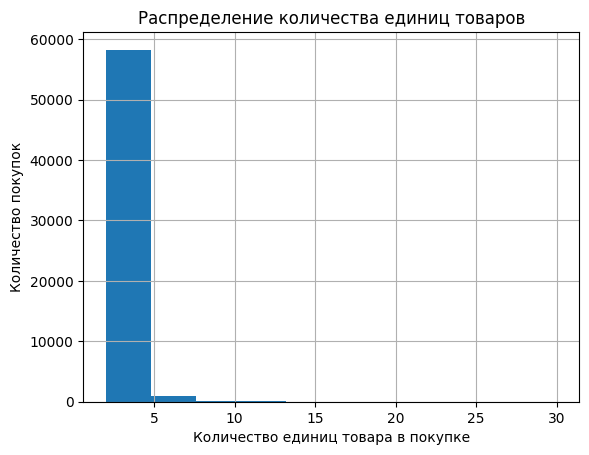

In [131]:
df['quantity'].hist(range=(2,30))
plt.title('Распределение количества единиц товаров')
plt.xlabel('Количество единиц товара в покупке')
plt.ylabel('Количество покупок')
plt.show()

Отметим, что несмотря на объединение дублирующихся покупок, перекос в распределении данных сохраняется. Подавляющее большинство покупателей приобретает до 6 единиц товара за раз. Важно отметить, что у нас нет оснований исключить данные о покупках более 20 единиц товара, так как такое покупательское поведение является возможным и ожидаемо мало представлено. В тоже время, приобретене небольшого количества единиц товара является, наоборот, ожидаемым. Соответственно, считаем, что данные имеют допустимое в данном случае распределение.

Расмотрим покупки с потенциально аномально высокой стоимостью.

In [132]:
df[df['price']>60000]

,client_id,price,category_ids,date,message_id,quantity
63766,1515915625553309277,85499.0,"['4', '29', '313', '1574']",2023-12-24,1515915625553309277-14352-6585585d7a711,1
109808,1515915625776653984,60200.0,"['4', '29', '310', '1577']",2023-08-26,1515915625776653984-13719-64e85f9332bc8,1
109809,1515915625776653984,63499.0,"['4', '29', '310', '1577']",2023-08-26,1515915625776653984-13719-64e85f9332bc8,1


Отметим следующее:
1. Максимальное значение действительно ощутимо отличается от остальных. Необходимо рассмотреть, были ли иные покупки товара данной категории.
2. Первые две строки выведенного фрагмента дс показывают данные об одном и том же покупателе, который приобрел один и тот же товар в один и тот же день, однако их цена заметно отличается. Можем предположить, что после первой покупки клиент получил индивидуальную скидку или же в целом на сайте цена опустилась для всех, что сподвигло клиента приобрести также и второй точно такой же товар. В любом случае, потенциально такая ситуация возможна, хотя и потенциально может оказать негативное влияние на результаты предсказания модели.
3. Можем предположить, что дорогие товары относятя к общей категории (вероятно, дорогостоящей). Вероятно, высокая цена приводит к меньшему количеству покупок в общем числе товарооборота, в связи с этим цены кажутся аномально высокими на фоне остальных.

In [133]:
#Для простоты работы преобразуем текущий список в действительно список целочисленных значений
#Для этого напишем функцию, преобразующую значения в список
def convert_to_int_list(s):
    s = s.strip("[]")  #Удаляем квадратные скобки
    el = s.split(", ")  #Разделяем строку на элементы
    #Ранее отметили наличие пустых строк, которые станут None на этом этапе. Пропускаем их
    int_e = []
    for e in el:
        try:
            int_value = int(e.strip("'"))
            int_e.append(int_value)
        except ValueError:
            pass  # Пропускаем элемент, если он не может быть преобразован в int
            
    return int_e

In [134]:
df['category_ids'] = df['category_ids'].apply(convert_to_int_list)

In [135]:
#Рассмотрим, были ли еще покупки самого дорогого товара за исследуемый период
target_set = set([4, 29, 313, 1574])
df[df['category_ids'].apply(set) == target_set].sort_values(by='price')

,client_id,price,category_ids,date,message_id,quantity
2914,1515915625468142907,2879.0,"[4, 29, 313, 1574]",2023-12-06,1515915625468142907-14252-65704c0bdd310,1
70666,1515915625559325926,5600.0,"[4, 29, 313, 1574]",2024-01-08,1515915625559325926-14441-659bd1eb92f2f,1
88747,1515915625587920003,7840.0,"[4, 29, 313, 1574]",2024-01-22,1515915625587920003-14513-65ae20cb6540e,1
121048,1515915625927697840,9241.0,"[4, 29, 313, 1574]",2023-12-18,1515915625927697840-14330-65806b91b396a,2
125197,1515915625980197822,11760.0,"[4, 29, 313, 1574]",2023-08-29,1515915625980197822-13733-64edb408546b9,2
52906,1515915625502430512,13999.0,"[4, 29, 313, 1574]",2023-07-13,1515915625776547099-13471-64abf25c6fe22,2
88748,1515915625587920003,13999.0,"[4, 29, 313, 1574]",2024-01-22,1515915625587920003-14513-65ae20cb6540e,1
91889,1515915625590727241,15049.0,"[4, 29, 313, 1574]",2023-07-07,1515915625776568054-13456-64a7dde275979,2
55810,1515915625507156992,15400.0,"[4, 29, 313, 1574]",2023-12-22,1515915625507156992-14334-65814d95d6ce4,2
128623,1515915626007437082,15904.0,"[4, 29, 313, 1574]",2024-02-14,1515915625953187492-14488-65a79766e8625,2


Обратим внимание, что диапазон цен крайне широк (от 2 879 до 85 499), соответственно, вероятнее всего, category_ids обозначает не путь до конкретного товара, а скорее путь до группы подкатегорий (например, Одежда - Женская одежда - Верхняя одежда - Пальто), что характерно для онлайн-магазинов.

Следовательно, оставляем данное значение, т.к. потенциально в дальнейшем модель может сталкиваться с товарами очень разного ценового сегмента даже в рамках одной категории.

Перепроверим остальные значения в столбце category_ids на корректность заполнения.

In [136]:
df['category_ids'].sort_values(ascending=False)

82472     [6060, 6059, 6076, 1153]
50146     [6060, 6059, 6076, 1153]
3381      [6060, 6059, 6076, 1153]
3383      [6060, 6059, 6076, 1153]
3384      [6060, 6059, 6076, 1153]
                    ...           
101114                          []
101115                          []
90918                           []
60154                           []
88736                           []
Name: category_ids, Length: 129018, dtype: object

Обратим внимание, что в столбце есть скрытые пропуски (пустые категории). Оценим количество таких строк и посмотрим, есть ли в них что-то общее.

In [137]:
df[df['category_ids'].apply(set) == set([])]

,client_id,price,category_ids,date,message_id,quantity
13,1515915625468061170,7.0,[],2023-03-26,1515915625468061170-11144-641ad2cda77a2,2
161,1515915625468066318,7.0,[],2022-12-21,1515915625468066318-8793-63a0585fc071d,2
221,1515915625468068308,7.0,[],2023-08-14,1515915625468068308-13647-64d9f80751dd6,2
224,1515915625468068447,10.0,[],2023-04-28,1515915625468068447-12252-644bc940a95ec,2
236,1515915625468068690,1.0,[],2023-04-19,1515915625468068690-11760-643673935a680,2
...,...,...,...,...,...,...
128956,1515915626009515678,7.0,[],2024-02-03,1515915625776547382-14587-65bcc2a78a468,2
128962,1515915626009608336,7.0,[],2024-02-06,1515915626009608336-14594-65c0879eaf1ec,2
128966,1515915626009661190,5.0,[],2024-02-07,1515915626009661190-14600-65c1e75b31a21,2
128972,1515915626009681249,7.0,[],2024-02-05,1515915625558930991-14595-65c085673111d,2


Предварительно можем предположить, что товар был удален из базы, в связи с чем был утерян id категории, либо же что это были тестовые данные, случано включенные в общую выборку (это могло бы объяснить низкую цену).

Проверим на примере первого клиента, посмотрим все его заказы по его id.

In [138]:
df[df['client_id']==1515915625468061170]

,client_id,price,category_ids,date,message_id,quantity
13,1515915625468061170,7.0,[],2023-03-26,1515915625468061170-11144-641ad2cda77a2,2
14,1515915625468061170,999.0,"[4, 28, 244, 432]",2023-06-17,1515915625468061170-13157-6483192913837,3
15,1515915625468061170,1609.0,"[4, 28, 260, 420]",2023-03-29,1515915625468061170-11208-6423f082d2fcb,2
16,1515915625468061170,2194.0,"[4, 28, 260, 420]",2023-03-29,1515915625468061170-11208-6423f082d2fcb,2
17,1515915625468061170,2195.0,"[4, 28, 260, 420]",2023-03-29,1515915625468061170-11208-6423f082d2fcb,2
18,1515915625468061170,2199.0,"[4, 28, 260, 420]",2023-03-29,1515915625468061170-11208-6423f082d2fcb,4
19,1515915625468061170,2200.0,"[4, 28, 260, 420]",2023-03-29,1515915625468061170-11208-6423f082d2fcb,2
20,1515915625468061170,2699.0,"[2, 18, 258, 441]",2023-03-26,1515915625468061170-11144-641ad2cda77a2,2


Во-первых, отметим, что клиент 5 раз заказал или один и тот же товар, или несколько товаров из одной категории в рамках одного дня, что выглядит возможным, но относительно неожиданным ввиду малой разницы в цене товаров.

Во-вторых, важно отметить, что заказ с пустым id не является единственным. Соответственно, нет оснований считать, что строки с пустыми id атегории являются тестовыми. Будем считать, что первая гипотеза более вероятна, и id был удален случайно.

Присвоим таким строкам дефолтное значение [0, 0, 0, 0]

In [139]:
df['category_ids'] = df['category_ids'].apply(lambda x: [0, 0, 0, 0] if not x else x)

Т.к. в сопроводительной информации указывалось, что количество значений в списке в данном столбце иногда может стать меньше 4, рассмотрим, сколько в целом сейчас таких данных в датасете.

In [140]:
df[df['category_ids'].apply(lambda x: len(x) < 4)]

,client_id,price,category_ids,date,message_id,quantity
692,1515915625468078544,174.0,"[4, 44, 428]",2022-12-24,1515915625468078544-8995-63a5b12244e4b,2
910,1515915625468083376,209.0,"[4, 44, 428]",2023-04-30,1515915625468083376-12218-644b83904c598,2
911,1515915625468083376,299.0,"[4, 44, 428]",2023-04-30,1515915625468083376-12218-644b83904c598,2
1125,1515915625468091813,55.0,"[4, 44, 489]",2023-09-26,1515915625468091813-13864-651141a531bb2,2
1568,1515915625468102493,174.0,"[4, 44, 428]",2023-09-09,1515915625468102493-3401-623044455acaf,2
...,...,...,...,...,...,...
128788,1515915626008163512,97.0,"[4, 44, 428]",2024-01-19,1515915626008163512-14499-65a9131c18577,2
128789,1515915626008163512,116.0,"[4, 44, 989]",2024-01-19,1515915626008163512-14499-65a9131c18577,3
128885,1515915626008924519,316.0,"[4, 44, 490]",2024-01-30,1515915625815783436-14546-65b39dc8ed15f,2
128887,1515915626008924519,499.0,"[4, 44, 490]",2024-01-30,1515915625815783436-14546-65b39dc8ed15f,2


In [141]:
df[df['category_ids'].apply(lambda x: len(x) < 4)]['category_ids'].value_counts()

category_ids
[4, 44, 428]          125
[4, 44, 501]          101
[4, 44, 1594]          69
[4, 44, 491]           68
[4, 44, 1381]          60
[4, 44, 489]           55
[4, 44, 490]           52
[4, 44, 430]           47
[4, 44, 1097]          24
[4, 44, 549]           23
[4, 44, 493]           20
[4, 44, 1564]          16
[4, 29, 503]           14
[4, 44, 1571]          12
[4, 44, 989]           10
[5562, 5597, 5782]      9
[4, 44, 528]            8
[4, 44, 494]            7
[4, 44, 492]            6
[4, 30, 503]            4
[4, 1822, 499]          4
[4, 44, 1600]           1
Name: count, dtype: int64

Данных немного, однако отметим, что они встречаются за разные периоды времени (и за 2022 год, и за 2024). Визуально проблематично предположить, какой именно уровень вложения был утерян. Однако, предположительно, утеряно не первое значение. Соответственно, для единообразия, преобразуем данные id категорий, дополнив их необходимым количеством нулей на конце.

In [142]:
df['category_ids'] = df['category_ids'].apply(lambda x: x + [0] * (4 - len(x)))

Теперь все значения в данном столбце приведены к единому виду.

Наконец, приведем столбец date к корректному виду

In [143]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
messages['date'] = pd.to_datetime(messages['date'], format='%Y-%m-%d')
messages['created_at'] = pd.to_datetime(messages['created_at'], format='%Y-%m-%d %H:%M:%S')

## Исследовательский анализ данных

Для начала оценим в целом, как распределяются данные по ценам на товары:

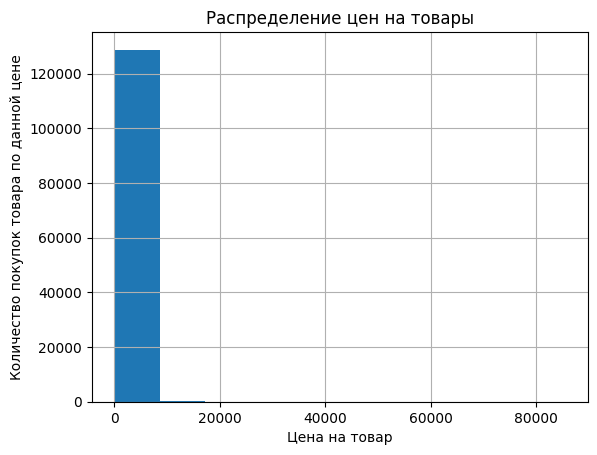

In [144]:
#В целом
df['price'].hist()
plt.title('Распределение цен на товары')
plt.xlabel('Цена на товар')
plt.ylabel('Количество покупок товара по данной цене')
plt.show()

In [145]:
df.describe()

,client_id,price,date,quantity
count,1.290180e+05,129018.000000,129018,129018.000000
mean,1.515916e+18,1264.694058,2023-02-26 10:13:27.292005888,1.577447
min,1.515916e+18,1.000000,2022-05-16 00:00:00,1.000000
25%,1.515916e+18,399.000000,2022-09-09 00:00:00,1.000000
50%,1.515916e+18,999.000000,2023-03-22 00:00:00,1.000000
75%,1.515916e+18,1750.000000,2023-06-28 00:00:00,2.000000
max,1.515916e+18,85499.000000,2024-02-16 00:00:00,96.000000
std,1.452710e+08,1375.315424,NaN,0.994979


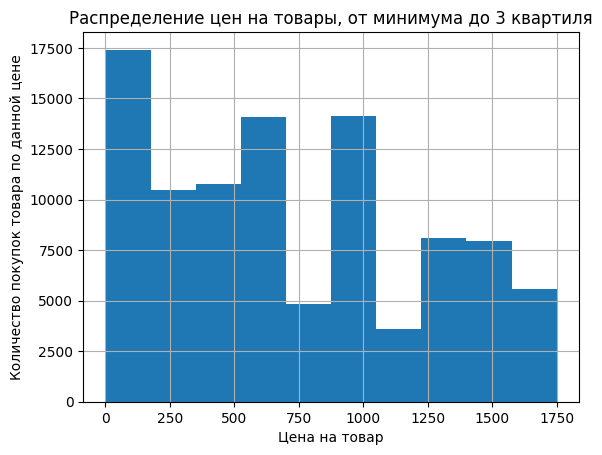

In [146]:
#В диапазоне до 3 квартиля
df['price'].hist(range=(1, 1750))
plt.title('Распределение цен на товары, от минимума до 3 квартиля')
plt.xlabel('Цена на товар')
plt.ylabel('Количество покупок товара по данной цене')
plt.show()

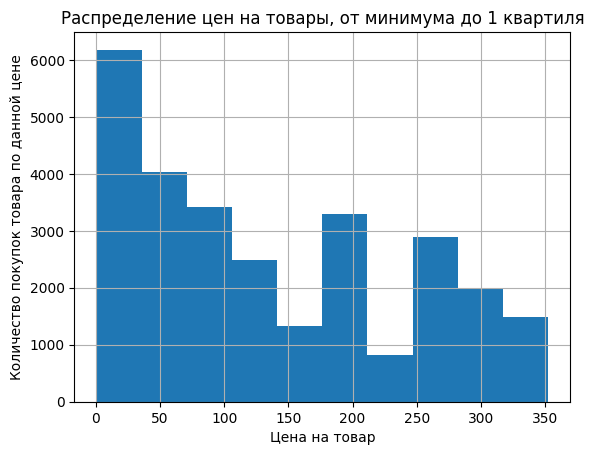

In [147]:
#В диапазоне до 1 квартиля
df['price'].hist(range=(1, 352))
plt.title('Распределение цен на товары, от минимума до 1 квартиля')
plt.xlabel('Цена на товар')
plt.ylabel('Количество покупок товара по данной цене')
plt.show()

Очевидно, что в основном интернет-магазин торгует достаточно недорогими товарами. Однако учтем, что это цена за единицу товара. Соответственно, эти данные не отражают реальную сумму чека покупателя. Кроме того, как ранее отметили, в ряде случаев цена в рамках одной категории может сильно отличаться. Соответственно, цены сами по себе не отражают реальный уровень денежного оборота и, возможно, в текущем виде не позволят модели более объективно рассматривать данные.

Соответственно, добавим столбец total, который будет отражать сумму покупки (т.е. произведение цены price на количество quantity).

In [148]:
df['total'] = df['price'] * df['quantity']

df.head()

,client_id,price,category_ids,date,message_id,quantity,total
0,1515915625468060902,199.0,"[4, 27, 176, 458]",2022-05-27,1515915625468060902-4617-6290657dac196,2,398.0
1,1515915625468060902,299.0,"[4, 28, 290, 422]",2022-05-27,1515915625468060902-4617-6290657dac196,1,299.0
2,1515915625468060902,999.0,"[4, 28, 244, 432]",2022-05-27,1515915625468060902-4617-6290657dac196,1,999.0
3,1515915625468060902,1299.0,"[4, 27, 1828, 1599]",2022-05-27,1515915625468060902-4617-6290657dac196,1,1299.0
4,1515915625468060902,1999.0,"[4, 28, 260, 420]",2022-05-27,1515915625468060902-4617-6290657dac196,2,3998.0


Оценим, как в целом распределяются покупки по количеству и по сумме в разрезе годов.

In [149]:
df_t = df
df_t['year'] = df['date'].dt.year

df_t_gb = df_t.groupby('year')[['quantity', 'total']].sum()
df_t_gb

,quantity,total
year,,
2022,82410,107092805.0
2023,110167,122146448.0
2024,10942,13305257.0


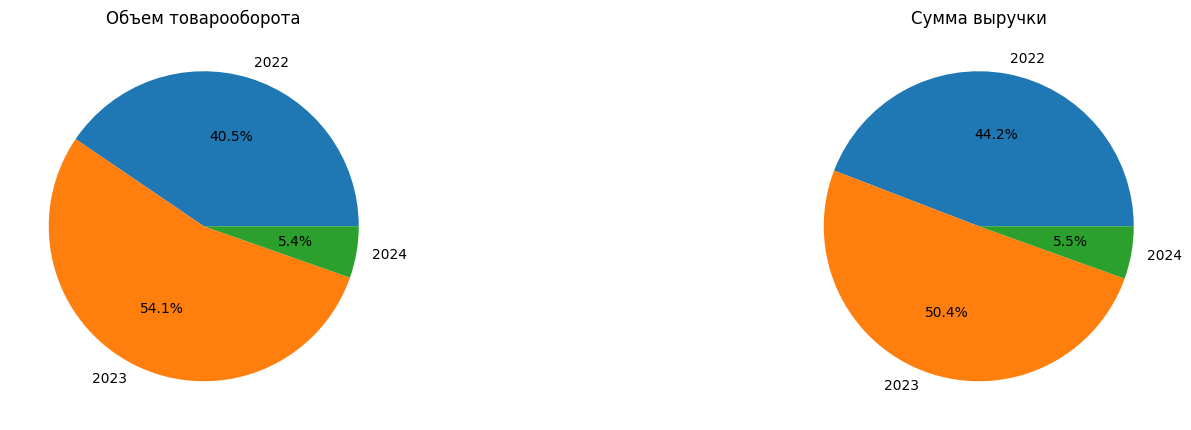

In [150]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
plt.subplots_adjust(wspace=1)

axes[0].pie(df_t_gb['quantity'], autopct='%1.1f%%', labels=df_t_gb['quantity'].index)
axes[0].set_title('Объем товарооборота')

axes[1].pie(df_t_gb['total'], autopct='%1.1f%%', labels=df_t_gb['total'].index)
axes[1].set_title('Сумма выручки')


plt.show()

Отметим как рост товарооборота, так и выручки с 2022 на 2023 год. При этом отметим, что в относительных значениях количество покупаемых товаров выросло значительнее чем объем выручки. Вероятно, это связано с особенностями ценообразования, а также общей ценовой и ассортиментной политикой.

Однако доля 2024 года слишком незначительна. Вероятно, это связано с нехваткой данных за этот год. Проверим, сколько в целом имеется покупок за каждый из годов.

In [151]:
df_t.groupby('year')['client_id'].count()

year
2022    57323
2023    65126
2024     6569
Name: client_id, dtype: int64

Действительно, за 2024 год данных значительно меньше, а 2023 показал прирост к 2022. Это может быть связано как с ростом количества покупок старыми клиентами (возврат клиентов), так и притоком новых.

Оценим количество уникальных клиентов за каждый год.

In [152]:
df_t.groupby('year')['client_id'].nunique()

year
2022    25459
2023    24561
2024     2517
Name: client_id, dtype: int64

Отметим, что в 2023 году количество уникальных клиентов уменьшилось практически на 1 тысячу в сравнении с 2022. Следовательно, можем предполагать (с учетом общего количества покупок, трех квартилей количества покупаемых товаров и количества уникальных покупателей), что либо вырос средний чек (покупатель за раз приобретает больше), либо клиенты стали чаще возвращаться и повторно совершать покупки.

Вероятнее первое, т.к. в дс target ранее отмечали, что подавляющее большинство клиентов не возвращаются. Вероятно, обучение модели и оценка значимости признаков позволит выявить неявные на текущем этапе закономерности, которые позволят улучшить маркетинговые активности.

Наконец, оценим воронку коммуникаций как на корректность.

Рассмотрим, как в целом идет распределение по количеству разных событий.

In [153]:
messages['event'].value_counts()

event
send           9058174
open           3052481
click           483326
purchase         62593
hard_bounce      19763
soft_bounce      10582
unsubscribe       2833
hbq_spam           823
complain           527
subscribe           85
close                1
Name: count, dtype: int64

In [154]:
messages['channel'].value_counts()

channel
mobile_push    7470472
email          5220716
Name: count, dtype: int64

Отметим следующее:
- Ожидаемо, больше всего событий send (т.е. отправлено). Это корректно.
- На втором месте open (открыто), что тоже ожидаемо.
- Третье место - click (нажатие), а четвертое - purchase (приобретение), т.е. целевое действие.

Это корректная воронка, так как на каждом этапе значение меньше чем на предыдущем. 

Отдельно оценим, к каким еще результатам привели рассылки клиентам:
- В 30 345 случаях рассылка не была доставлена клиенту, из них 19 763 (hard_bounce) вызваны ошибкой в адресе получателя (например, несуществующий почтовый ящик или же ящик был заблокирован) и 10 582 (soft_bounce) вызваны временной проблемой с доставкой письма (например, почтовый ящик переполнен). Они требуют отдельного рассмотрения отдела маркетинга, так как фактически означают впустую потраченные на организацию рассылки средства.
- В 823 случаях рассылка попала в категорию Спам (hbq_spam), что также могло снизить итоговую конверсию.
- В 2 833 случаях пользователь отписался от рассылки (unsubscribe), а в 527 оставил жалобу (complain) (что может быть вызвано тем, что ранее он уже отписывался от рассылки и получил ее вновь).
- Только в 85 случаях пользователи подписались на рассылку (subscribe), что является очень малым значением в сравнении с общим количеством отправленных рассылок (на уровне погрешности).

Среди имеюшихся условно можем выделить 4 последовательных события:
1. Send
2. Open ИЛИ hbq_spam, hard_bounce, soft_bounce
3. Click ИЛИ unsubscribe, subscribe, complain, close
4. Purchase

Напишем функцию, которая добавит информацию о том, какой это этап события

In [155]:
def event_num(event):
    if event == 'send':
        return 1
    elif event in ('open', 'hbq_spam', 'hard_bounce', 'soft_bounce'):
        return 2
    elif event == 'purchase':
        return 4
    else:
        return 3

In [156]:
#Добавляем новый столбец
messages['stage'] = messages['event'].apply(event_num)

Посмотрим на воронку в таком формате.

In [157]:
messages['stage'].value_counts()

stage
1    9058174
2    3083649
3     486772
4      62593
Name: count, dtype: int64

Логика сохраняется.

Наконец оценим сохраняется ли логика даты и времени событий в рамках одного пользователя. Рассмотрим одного из тех, кто совершил, согласно данному датасету, целевое действие (Purchase).

In [158]:
messages[messages['event']=='purchase'].head(10)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at,stage
27,4439,1515915625498693110,1515915625498693110-4439-62834130c8234,purchase,email,2022-05-19,2022-05-19 02:05:20,4
54,4439,1515915625558950747,1515915625558950747-4439-6283411f3ad55,purchase,email,2022-05-19,2022-05-19 03:15:19,4
58,4439,1515915625490515072,1515915625490515072-4439-6283411e33838,purchase,email,2022-05-19,2022-05-19 03:19:12,4
61,4439,1515915625490515072,1515915625490515072-4439-6283411e33838,purchase,email,2022-05-19,2022-05-19 03:25:13,4
62,4439,1515915625490515072,1515915625490515072-4439-6283411e33838,purchase,email,2022-05-19,2022-05-19 03:27:40,4
63,2499,1515915625566604599,1515915625566604599-2499-61d2a06cba693,purchase,email,2022-05-19,2022-05-19 03:27:44,4
64,4439,1515915625490515072,1515915625490515072-4439-6283411e33838,purchase,email,2022-05-19,2022-05-19 03:31:09,4
73,4439,1515915625558672149,1515915625558672149-4439-6283411cccf7b,purchase,email,2022-05-19,2022-05-19 03:44:48,4
134,4439,1515915625489563067,1515915625489563067-4439-62834137445f2,purchase,email,2022-05-19,2022-05-19 05:05:22,4
3305,4439,1515915625697770146,1515915625697770146-4439-62834149534be,purchase,email,2022-05-19,2022-05-19 06:35:36,4


In [159]:
messages[messages['message_id'] == '1515915625490515072-4439-6283411e33838']

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at,stage
22,4439,1515915625490515072,1515915625490515072-4439-6283411e33838,open,email,2022-05-19,2022-05-19 02:03:22,2
39,4439,1515915625490515072,1515915625490515072-4439-6283411e33838,click,email,2022-05-19,2022-05-19 02:41:02,3
58,4439,1515915625490515072,1515915625490515072-4439-6283411e33838,purchase,email,2022-05-19,2022-05-19 03:19:12,4
61,4439,1515915625490515072,1515915625490515072-4439-6283411e33838,purchase,email,2022-05-19,2022-05-19 03:25:13,4
62,4439,1515915625490515072,1515915625490515072-4439-6283411e33838,purchase,email,2022-05-19,2022-05-19 03:27:40,4
64,4439,1515915625490515072,1515915625490515072-4439-6283411e33838,purchase,email,2022-05-19,2022-05-19 03:31:09,4


In [160]:
messages[messages['message_id'] == '1515915625558672149-4439-6283411cccf7b']

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at,stage
71,4439,1515915625558672149,1515915625558672149-4439-6283411cccf7b,open,email,2022-05-19,2022-05-19 03:38:22,2
72,4439,1515915625558672149,1515915625558672149-4439-6283411cccf7b,click,email,2022-05-19,2022-05-19 03:38:43,3
73,4439,1515915625558672149,1515915625558672149-4439-6283411cccf7b,purchase,email,2022-05-19,2022-05-19 03:44:48,4


In [161]:
messages[messages['message_id'] == '1515915625697770146-4439-62834149534be']

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at,stage
3305,4439,1515915625697770146,1515915625697770146-4439-62834149534be,purchase,email,2022-05-19,2022-05-19 06:35:36,4
54514,4439,1515915625697770146,1515915625697770146-4439-62834149534be,open,email,2022-05-21,2022-05-21 19:57:16,2


In [162]:
messages[messages['bulk_campaign_id'] == 4439]['event'].unique()

array(['open', 'click', 'purchase', 'unsubscribe', 'complain'],
      dtype=object)

Во-первых, отметим, что в 3 случайно выбранных рассылках, отсутствует информация об отправке (проверка по номеру идентификатора компании показала, что по ней в целом отсутствует запись об отправке). Соответственно, часть данных утеряна.

Во-вторых, по одному из пользователей отметим, что он совершил несколько покупок после получения и перехода по рассылке, все из которых отнесли к одному сообщению. Соответственно, реальная конверсия в разрезе каждого покупателя ниже (что частично объясняет малую долю клиентов, совершивших целевое действие в датасете target).

В-третьих, по третьему пользователю отметим, что отсутствует также запись о нажатии на ссылку в письме, более того, покупка была совершена несколько дней ДО получения письма. Соответственно, это является грубой ошибкой в данных.

В результате можем сделать вывод о том, что как минимум часть данных содержит некорректную информацию о проведенных маркетинговых мероприятиях. Соответственно, ранее рассмотренная воронка, не смотря на свой корректный вид, не отражает действительность. Рекомендуется пересмотреть процесс сбора данных с учетом выявленных ошибок.

В рамках данного исследования данные будут использоваться не в полном объеме ввиду выявленных нарушений.

# Разработка модели, 1 версия

Так как в данной задаче требуется предсказать, готов или нет покупатель совершить покупку в ближайшее время, то мы имеем дело с бинарной классификацией (только 2 варианта ответа, да или нет).

В данном случае будем использовать модель градиентного бустинга CatBoost (а именно CatBoostClassifier).

В первой итерации обучим модель в формате "как есть", т.е. используем данные в том формате и объеме, что они есть сейчас.

## Подготовка данных

Нам необходимо агрегировать данные по id клиента, так как целью является предсказание того, совершит ли клиент повторную покупку в течение 90 дней или нет. Основные сложности здесь в неоднородности данных: клиенты могут совершать покупки в разные дни, в разных категориях и в разных колиествах. Соответственно, грубое объединение данных только по id клиента может привести к потере данных.

Учтем, что в датасете target данные по 49 849 клиентам без привязки к конкретному году или иной дате.
Оценим текущее количество уникальных значений id клиентов в датасете df.

In [163]:
print(f'\033[1mКоличество уникальных id клентов:\n\033[0m{df['client_id'].nunique()}\n')

Количество уникальных id клентов:
49849



Данные по клиентам совпадают до единиц. Так как в целевых значениях нет привязки к дате, соответственно клиентов необходимо оценивать совокупно.

Удаляем столбец price ввиду его неактуальности (он формально учитывается в столбце total). Данные по году убираем, так как они не позволят рассматривать данные за весь период активности клиента.

In [164]:
#Убираем лишние признаки
df = df.drop(['year', 'price'], axis=1)

Т.к. в исходных данных есть столбец category_ids, имеющий тип данных list, построить матрицу с ним не получится. Однако возможно наличие взаимосвязи этого параметра с, например, ценой, соответственно эти данные необходимо также рассмотреть. Так как одно и тоже число у разных товаров обозначает однуи ту же категорию/подкатегорию, то "свернем" категории до первой в списке. Тем самым оставим главную категорию, которая вероятнее всего обозначает основную группу товаров (например, Одежда, Обувь, Дом и сад или иное).

In [165]:
df['category_ids'] = df['category_ids'].apply(lambda x: x[0] if len(x) > 0 else None)

In [166]:
# Приведем оставшиеся элементы к типу int
df['category_ids'] = pd.to_numeric(df['category_ids'], errors='coerce').astype('int')

In [167]:
#Проверим, что данные преобразились корректно
df['category_ids'].unique()

array([   4,    0,    2, 5562, 6060, 5963,    1,    5,    3])

Агрегируем данные по столбцу client_id. 

Суммируем значения в столбце total и quantity (считаем общие траты клиента и количество купленных товаров за весь период активности). В category_ids выбираем наиболее часто встречающееся значение. В столбце date оставляем дату последней покупки, а в message_id оставим данные по рассылке, которую связывают с этой датой.

In [168]:
def agg_df(dataframe):
    #Добавим функцию нахождения наиболее часто встречающегося значения
    def most_freq(row):
        return row.value_counts().index[0]

    #Группируем данные и применяем необходимые функции к столбцам
    gb_new_df = dataframe.groupby('client_id').agg({
        'category_ids':most_freq,
        'date':'max',
        'quantity':'sum',
        'total':'sum'
    }).reset_index()

    #Добавляем корректный message_id с привязкой к дате
    gb_new_df = gb_new_df.merge(dataframe[['client_id', 'date', 'message_id']].drop_duplicates(), on = ['client_id', 'date'], how = 'left')
    
    return gb_new_df

In [169]:
df_1 = agg_df(df)

df_1.head(10)

,client_id,category_ids,date,quantity,total,message_id
0,1515915625468060902,4,2022-05-27,7,6993.0,1515915625468060902-4617-6290657dac196
1,1515915625468061003,4,2023-01-04,7,16235.0,1515915625468061003-9148-63b54b04855a4
2,1515915625468061099,4,2022-05-17,1,299.0,1515915625468061099-4439-62834141aa538
3,1515915625468061100,4,2024-02-10,2,2098.0,1515915625468061100-14623-65c5c55eeb9e0
4,1515915625468061170,4,2023-06-17,19,33601.0,1515915625468061170-13157-6483192913837
5,1515915625468061514,4,2022-07-30,1,999.0,1515915625468061514-5707-62e3823619b1f
6,1515915625468061877,5562,2022-08-19,1,1499.0,1515915625468061877-5922-62ff354653bfd
7,1515915625468061975,4,2022-07-27,1,299.0,1515915625468061975-5662-62e0e6198eac6
8,1515915625468061994,6060,2022-12-14,8,1012.0,1515915625468061994-8663-6399c90f8b7aa
9,1515915625468062158,4,2023-04-28,4,6096.0,1515915625468062158-12218-644b83bd8e4c0


In [170]:
#Проверяем, что никто из клиентов не был утерян в процессе преобразования.
print(f'\033[1mКоличество уникальных id клентов:\n\033[0m{df_1['client_id'].nunique()}\n')

Количество уникальных id клентов:
49849



Данные сохранены по всем клиентам и преобразованы.

In [171]:
#Добавляем целевой признак
df_1 = df_1.merge(target, on = 'client_id', how='left')

In [172]:
df_1.head()

,client_id,category_ids,date,quantity,total,message_id,target
0,1515915625468060902,4,2022-05-27,7,6993.0,1515915625468060902-4617-6290657dac196,0
1,1515915625468061003,4,2023-01-04,7,16235.0,1515915625468061003-9148-63b54b04855a4,1
2,1515915625468061099,4,2022-05-17,1,299.0,1515915625468061099-4439-62834141aa538,0
3,1515915625468061100,4,2024-02-10,2,2098.0,1515915625468061100-14623-65c5c55eeb9e0,0
4,1515915625468061170,4,2023-06-17,19,33601.0,1515915625468061170-13157-6483192913837,0


## Проверка данных на мультиколлинеарность

Корреляционный анализ будем проводить с помощью построения матрицы phik, т.к. она учитывает не только количественные, но и качественные признаки.

Оценим текущие данные на наличие мультиколлинеарности. Исключаем столбцы client_id и message_id из-за их большого объема уникальных значений, но малой информативности в текущем виде для модели.

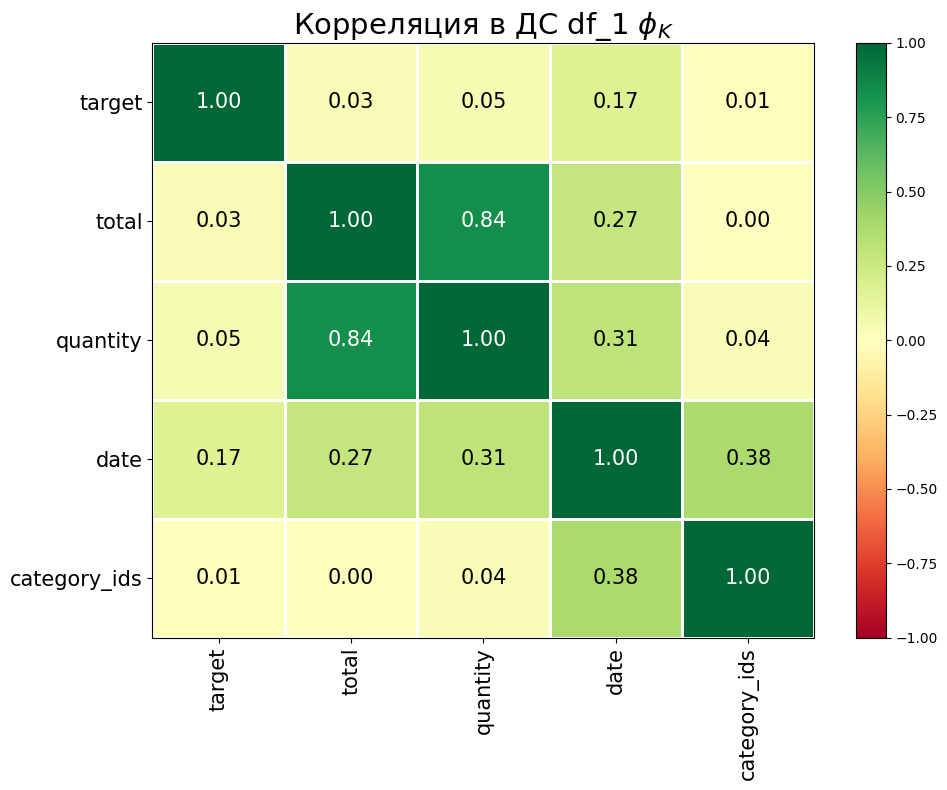

In [173]:
interval_cols = ['quantity', 'total']

phik_overview = df_1.drop(['client_id', 'message_id'], axis=1).phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"Корреляция в ДС df_1 $\phi_K$",
    fontsize_factor=1.5,
    figsize=(10, 8))

Отметим, что между столбцами quantity и total высокая зависимость (что, вероятно, вызвано обилием покупок 1 и 2 единиц товара).

Также отметим сильную связь категории товара и даты. Возможно это связно с датами акций на определенные категории товаров.

Мультиколлинеарность в данных не обнаружена.

## Обучение модели 

In [174]:
#Делим данные на выборки
RANDOM_STATE = 42

X = df_1.drop(['client_id', 'message_id', 'target'], axis=1)
y = df_1['target']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25, random_state = RANDOM_STATE)

In [175]:
cat_features = ['category_ids']

model = CatBoostClassifier(loss_function='Logloss', iterations=150)

model.fit(X_train, y_train, cat_features=cat_features, verbose=10)

Learning rate set to 0.275615
0:	learn: 0.4735896	total: 25.8ms	remaining: 3.85s
10:	learn: 0.0987717	total: 287ms	remaining: 3.63s
20:	learn: 0.0896215	total: 561ms	remaining: 3.45s
30:	learn: 0.0887926	total: 786ms	remaining: 3.02s
40:	learn: 0.0883124	total: 998ms	remaining: 2.65s
50:	learn: 0.0879239	total: 1.22s	remaining: 2.37s
60:	learn: 0.0876630	total: 1.45s	remaining: 2.12s
70:	learn: 0.0873654	total: 1.68s	remaining: 1.87s
80:	learn: 0.0870485	total: 1.91s	remaining: 1.63s
90:	learn: 0.0868081	total: 2.14s	remaining: 1.39s
100:	learn: 0.0866731	total: 2.37s	remaining: 1.15s
110:	learn: 0.0864275	total: 2.6s	remaining: 913ms
120:	learn: 0.0862019	total: 2.87s	remaining: 688ms
130:	learn: 0.0857645	total: 3.1s	remaining: 450ms
140:	learn: 0.0854785	total: 3.33s	remaining: 213ms
149:	learn: 0.0854163	total: 3.54s	remaining: 0us


In [176]:
prob = model.predict_proba(X_test)
prob_one = prob[:, 1]

print(roc_auc_score(y_test, prob_one))

0.6793788800849534


На текущий момент модель выдает точность в 0,68. Это относительно хороший показатель работы модели (она не ошибается в почти 70% случаев).

Однако попробуем улучшить результаты работы модели.

# Разработка модели, 2 версия

## Добавление новых данных

Т.к. мы предполагаем, что возврат клиента происходит в том числе благодаря маркетинговым рассылкам, то учтем эти данные в общем массиве данных.

Ключевым является итоговое событие, которое клиент совершил последним. Соответственно, добавляем данные из строки с максимальным числом в столбце stage. 

In [177]:
#Формируем выборку строк по message_id с максимальным stage для каждого
max_stage = messages.groupby(['message_id']).agg({'stage':'max'}).reset_index()
max_stage.head(10)

,message_id,stage
0,1515915625468060902-10022-63e5ededd911f,1
1,1515915625468060902-10218-63ef56ed94656,1
2,1515915625468060902-10289-63f35a8a9ff35,1
3,1515915625468060902-10373-63f5cbba42484,1
4,1515915625468060902-10507-63ff04f701e74,1
5,1515915625468060902-10619-6401dce84e082,1
6,1515915625468060902-10671-6405d1340c2f3,1
7,1515915625468060902-10792-640ad904f0f1f,1
8,1515915625468060902-10988-64141015e4816,1
9,1515915625468060902-11144-641ad1d82ed4a,2


In [195]:
df_2 = df_1.merge(max_stage, on = 'message_id', how = 'left')
df_2.head()

,client_id,category_ids,date,quantity,total,message_id,target,stage
0,1515915625468060902,4,2022-05-27,7,6993.0,1515915625468060902-4617-6290657dac196,0,4.0
1,1515915625468061003,4,2023-01-04,7,16235.0,1515915625468061003-9148-63b54b04855a4,1,4.0
2,1515915625468061099,4,2022-05-17,1,299.0,1515915625468061099-4439-62834141aa538,0,NaN
3,1515915625468061100,4,2024-02-10,2,2098.0,1515915625468061100-14623-65c5c55eeb9e0,0,4.0
4,1515915625468061170,4,2023-06-17,19,33601.0,1515915625468061170-13157-6483192913837,0,4.0


Обратим внимание, что по некоторым клиентам есть пропущеные значения. Вероятно данные по ним входят в часть утерянных данных, что упоминалось ранее при исследовательском анализе данных.

Добавим данные по каналам привлечения и событиям по id сообщения. Пропущенные значения заменим на 1 (для столбца stage, так как предполагаем, что как минимум данный этап был пройден), в столбец channel же внесем No (так как нет значения, которое можем принять за вариант по умолчанию).

In [196]:
df_2 = df_2.merge(messages[['message_id', 'channel', 'stage']], on = ['message_id', 'stage'], how = 'left').drop_duplicates()

df_2['channel'] = df_2['channel'].fillna('No')
df_2['stage'] = df_2['stage'].fillna(1)

df_2.head()

,client_id,category_ids,date,quantity,total,message_id,target,stage,channel
0,1515915625468060902,4,2022-05-27,7,6993.0,1515915625468060902-4617-6290657dac196,0,4.0,email
5,1515915625468061003,4,2023-01-04,7,16235.0,1515915625468061003-9148-63b54b04855a4,1,4.0,email
6,1515915625468061099,4,2022-05-17,1,299.0,1515915625468061099-4439-62834141aa538,0,1.0,No
7,1515915625468061100,4,2024-02-10,2,2098.0,1515915625468061100-14623-65c5c55eeb9e0,0,4.0,mobile_push
8,1515915625468061170,4,2023-06-17,19,33601.0,1515915625468061170-13157-6483192913837,0,4.0,email


In [181]:
#Перепроверим, что данные не утеряны
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49928 entries, 0 to 71497
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   client_id     49928 non-null  int64         
 1   category_ids  49928 non-null  int32         
 2   date          49928 non-null  datetime64[ns]
 3   quantity      49928 non-null  int64         
 4   total         49928 non-null  float64       
 5   message_id    49928 non-null  object        
 6   target        49928 non-null  int64         
 7   event         49928 non-null  object        
 8   channel       49928 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(3), object(3)
memory usage: 3.6+ MB


## Проверка данных на мультиколлинеарность

Перепроверим, что, с учетом новых данных, мультиколлинеарность отсутствует.

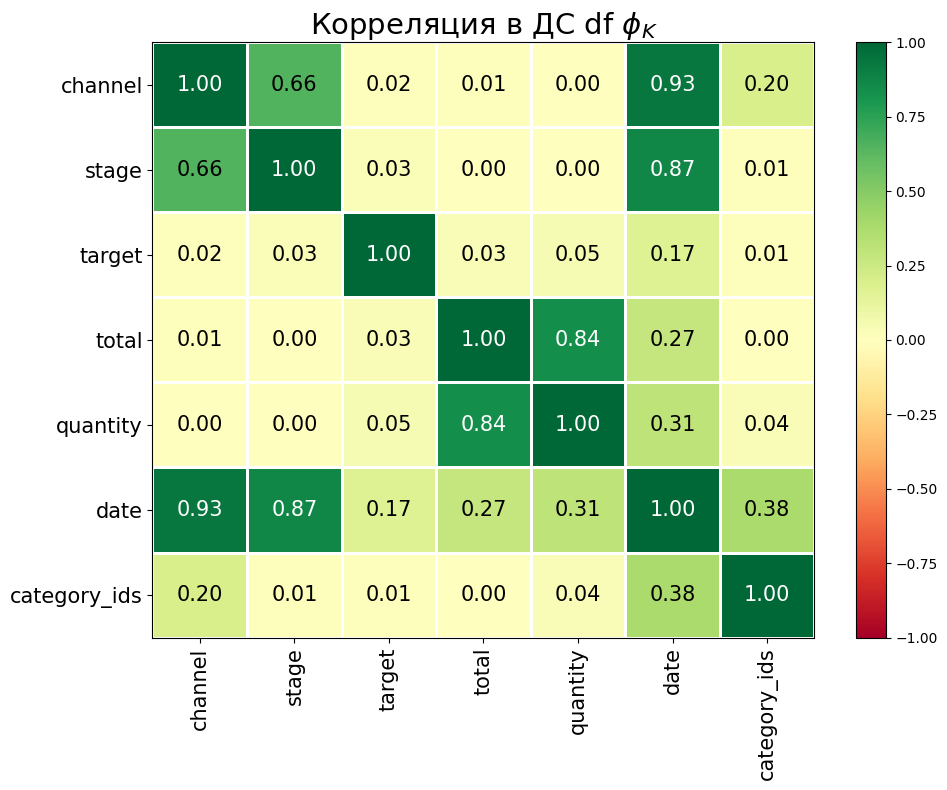

In [197]:
interval_cols = ['quantity', 'price', 'total']

phik_overview = df_2.drop(['client_id', 'message_id'], axis=1).phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"Корреляция в ДС df $\phi_K$",
    fontsize_factor=1.5,
    figsize=(10, 8))

Традиционно принято считать, что значения выше 0,9 по модулю свидетельствуют о наличии мультиколлинеарности. Обратим внимание, что столбец date демонстрирует сильную линейную зависимость сразу с несколькими другими столбцами, при этом со столбцом channel эта связь превышает порог.

Отметим, что при этом date имеет большую корреляцию с целевым показателем, чем channel.

Устраним мультиколлинеарность удалением одного из столбцов, однако сделаем это в разных датафреймах. А после дополнительно сравним, какая из моделей покажет себя лучше по метрике.

In [198]:
df_c = df_2.drop('date', axis=1)
df_d = df_2.drop('channel', axis=1)

Сначала обучим и оценим модель на данных из дф df_c (без даты)

In [199]:
X_c = df_c.drop(['client_id', 'message_id', 'target'], axis=1)
y_c = df_c['target']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_c,
    y_c,
    test_size=0.25, random_state = RANDOM_STATE)

In [202]:
cat_features_c = ['category_ids', 'channel']

model_c = CatBoostClassifier(loss_function='Logloss', iterations=150)

model_c.fit(X_train_c, y_train_c, cat_features=cat_features_c, verbose=10)

Learning rate set to 0.275615
0:	learn: 0.4736815	total: 30.1ms	remaining: 4.49s
10:	learn: 0.1005268	total: 290ms	remaining: 3.66s
20:	learn: 0.0927668	total: 488ms	remaining: 3s
30:	learn: 0.0921117	total: 686ms	remaining: 2.63s
40:	learn: 0.0916089	total: 885ms	remaining: 2.35s
50:	learn: 0.0914845	total: 1.12s	remaining: 2.17s
60:	learn: 0.0913810	total: 1.35s	remaining: 1.98s
70:	learn: 0.0912427	total: 1.59s	remaining: 1.77s
80:	learn: 0.0909719	total: 1.84s	remaining: 1.57s
90:	learn: 0.0908165	total: 2.1s	remaining: 1.36s
100:	learn: 0.0907046	total: 2.34s	remaining: 1.14s
110:	learn: 0.0905362	total: 2.58s	remaining: 907ms
120:	learn: 0.0902671	total: 2.82s	remaining: 676ms
130:	learn: 0.0900379	total: 3.06s	remaining: 444ms
140:	learn: 0.0899262	total: 3.3s	remaining: 211ms
149:	learn: 0.0898502	total: 3.51s	remaining: 0us


In [203]:
prob_c = model_c.predict_proba(X_test_c)
prob_one_c = prob_c[:, 1]

print(roc_auc_score(y_test_c, prob_one_c))

0.6587560583782606


Теперь на данных без канала рассылки

In [204]:
X_d = df_d.drop(['client_id', 'message_id', 'target'], axis=1)
y_d = df_d['target']

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    X_d,
    y_d,
    test_size=0.25, random_state = RANDOM_STATE)

In [206]:
cat_features_d = ['category_ids']

model_d = CatBoostClassifier(loss_function='Logloss', iterations=150)

model_d.fit(X_train_d, y_train_d, cat_features=cat_features_d, verbose=10)

Learning rate set to 0.275615
0:	learn: 0.4735347	total: 30.5ms	remaining: 4.55s
10:	learn: 0.0988768	total: 275ms	remaining: 3.48s
20:	learn: 0.0896486	total: 528ms	remaining: 3.24s
30:	learn: 0.0888214	total: 765ms	remaining: 2.94s
40:	learn: 0.0881834	total: 1s	remaining: 2.66s
50:	learn: 0.0879240	total: 1.23s	remaining: 2.39s
60:	learn: 0.0876850	total: 1.47s	remaining: 2.14s
70:	learn: 0.0873295	total: 1.71s	remaining: 1.9s
80:	learn: 0.0870919	total: 1.94s	remaining: 1.66s
90:	learn: 0.0869228	total: 2.18s	remaining: 1.41s
100:	learn: 0.0867147	total: 2.42s	remaining: 1.17s
110:	learn: 0.0864758	total: 2.65s	remaining: 932ms
120:	learn: 0.0863380	total: 2.89s	remaining: 692ms
130:	learn: 0.0861876	total: 3.12s	remaining: 453ms
140:	learn: 0.0860137	total: 3.36s	remaining: 214ms
149:	learn: 0.0856798	total: 3.57s	remaining: 0us


In [207]:
prob_d = model_d.predict_proba(X_test_d)
prob_one_d = prob_d[:, 1]

print(roc_auc_score(y_test_d, prob_one_d))

0.6773474513968305


Добавление новых данных не повысило точность работы модели, а напротив - сократило. Судя по всему, из-за перекосов в данных модель переобучается на более типичных данных, из-за чего снижается точность ее работы на других данных.

Вернемся к первому варианту модели, попробуем повысить ее точность снижением количества итераций.

In [210]:
model = CatBoostClassifier(loss_function='Logloss', iterations=45)

model.fit(X_train, y_train, cat_features=cat_features, verbose=10)

prob = model.predict_proba(X_test)
prob_one = prob[:, 1]

print(roc_auc_score(y_test, prob_one))

Learning rate set to 0.5
0:	learn: 0.3429872	total: 26.9ms	remaining: 1.18s
10:	learn: 0.0900145	total: 275ms	remaining: 850ms
20:	learn: 0.0885410	total: 534ms	remaining: 610ms
30:	learn: 0.0880068	total: 748ms	remaining: 338ms
40:	learn: 0.0874611	total: 990ms	remaining: 96.6ms
44:	learn: 0.0871572	total: 1.09s	remaining: 0us
0.6826861419702662


Это позволило незначительно поднять точность модели. Остановимся на данном варианте.

## Обучение модели

# Оценка значимости признаков

Оценим важность признаков для лучшей модели, построим график важности и рассмотрим его детально.

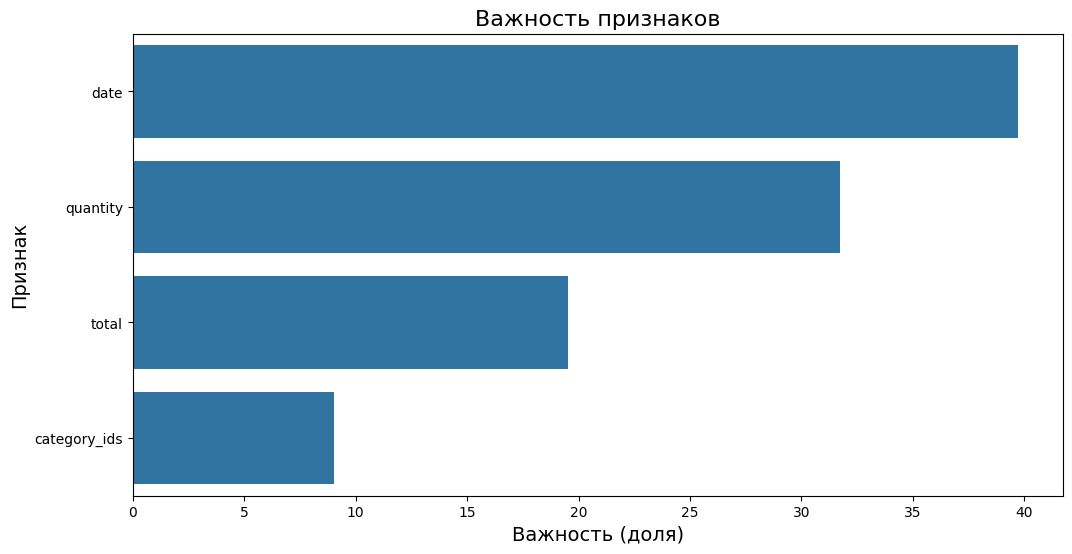

In [191]:
feature_importances = pd.DataFrame(
    {
        'Feature': X.columns,
        'Importance': model.get_feature_importance()
    }).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 6))

ax = sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importances
)


ax.set_title('Важность признаков', fontsize=16)
ax.set_xlabel('Важность (доля)', fontsize=14)
ax.set_ylabel('Признак', fontsize=14)

plt.show()

Отметим, что достаточно ожидаемо наибольшую важность среди признаком имеет date (как отмечали ранее, ряд других данных имеют прямую линейную зависимость от даты).

Наименьшую же важность имеет наиболее популярная категория покупателя, что также объяснимо: так как категории представлены в укрупненном варианте, то включают в себя достаточно широкий диапазон товаров.

# Вывод

По итогу проведенного анализа удалось установить следующее:

Общая информация:
- Интернет-магазин демонстрирует рост в товарообороте и выручке (в сравнении данных за 2023 и 2022 года), однако количество уникальных пользователей сокращается.
- Не все клиенты из числа совершивших покупки получали рекламные рассылки.

Дата:
- Дата покупки имеет большое влияние и, в том числе, может повлиять на то, совершит ли клиент повторную покупку в течение 90 дней или нет.
- Вероятно, с учетом выявленной значительной разницы на товары одной и той же категории, это может быть связано с сезонными акциями или индивидуальными предпложениями.
- Так как дата покупки имеет ключевое значение, стоит обратить внимание на даты и время проведения рассылок для достижения наиболее оптимального результата.